# Project Milestone 2
> CS-401 - Applied Data Analysis

> *Group Padawan - Fall 2024*

>*Maxime Ducourau*, *Mehdi Zoghlami*, *Léopold Henry*, *Martin Catheland*, *Jean Perbet*

This notebook is an exploratory analysis of the [YouNiverse](https://zenodo.org/records/4650046) dataset, which contains data about **137k** english-speaking [YouTube](https://youtube.com) channels having more than **10k** subscribers, and their **73M** videos, uploaded between **2005** and **2019**. 

We chose to focus on the **gaming** category, which is one of the most popular on YouTube. We will try to adress the following **research questions**:
- What are the most popular games on YouTube ?
- Is there a link between real-world gaming events and releases, and the popularity of games on YouTube ?
- What are the most linked communities in the gaming category ?

Due to the considerable size of the dataset, we pre-filtered the original dataset to only keep the **gaming videos**, their **comments**, the **channels** that have uploaded at least one video in the gaming category and their **time-series**. We also took advantage of it to remove some useless / heavy-weight fields.

This pre-filtering is available in the notebook `prefiltering.ipynb`. Below is a summary of the datasets at our disposal, after pre-filtering.

| File | Description | Fields |
| --- | --- | -- |
| `gaming_videos.tsv` | Videos | `title`, `tags`, `upload_date`, `view_count`, `like_count`, `dislike_count`, `duration`, `channel_id`, `display_id` |
| `gaming_comments.tsv` | Comments | `author`, `video_id`|
| `gaming_channels.tsv` | Channels | `channel_id`, `channel_name`, `subscribers` |
| `gaming_timeseries.tsv` | Channels time-series | `channel_id`, `datetime`, `views`, `delta_views`, `subs`, `delta_subs`, `videos`, `delta_videos` |

We'll first examine the datasets to understand our data, its distribution and its stastistical properties, and then we'll perform some initial opersations to try to answer our previously mentioned research questions. Let's first load the libraries and create the constants we will need later.

It is important to notice that we will use the [`polars`](https://pola.rs) library for large datasets (i.e. for videos metadata and comments) throughout this notebook, which is a blazingly fast data frame library allowing lazy evaluation and parallel processing. For cells which take a long time to run, we provide the expected time to run the cell as a comment.

In [1]:
# data frames
import pandas as pd
import polars as pl

# math
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import networkx as nx


# space partitioning
import community.community_louvain as community

# utils
import sys
sys.path.insert(0, '../')
from src.utils import *

# progress tracking
from tqdm import tqdm
tqdm.pandas()

# turn off warnings
import warnings
warnings.filterwarnings("ignore")

# youniverse paths
VIDEOS_PATH = "../data/youniverse/filtered/gaming_videos.tsv"
CHANNELS_PATH =  "../data/youniverse/filtered/gaming_channels.tsv"
TIMESERIES_PATH = "../data/youniverse/filtered/gaming_timeseries.tsv"
COMMENTS_PATH =  "../data/youniverse/filtered/gaming_comments.tsv"

# additional paths
GAMES_PATH = "../data/games.csv"
ESPORTS_PATH = "../data/esports_tournaments.csv"
WORDS_PATH = "../data/words_alpha.txt"

# random seed
RANDOM_STATE = 1

## Channel metadata

Let's first explore the **channels metadata**, and get some statistics.

In [2]:
channels_df = pd.read_csv(CHANNELS_PATH, sep='\t')

We quickly check the number of missing values in order to drop them if possible.

In [3]:
channels_df.isna().sum()

channel_id      0
channel_name    2
subscribers     0
videos          0
dtype: int64

As we can see, the number of missing values is pretty negligible, so we can drop them.

In [4]:
channels_df = channels_df.dropna()

In [5]:
channels_df.describe()

,subscribers,videos
count,2.014100e+04,20141.000000
mean,2.020391e+05,751.022839
std,1.052091e+06,1986.786358
min,1.000000e+04,10.000000
25%,1.800000e+04,105.000000
50%,3.870000e+04,286.000000
75%,1.247350e+05,768.000000
max,1.010000e+08,134606.000000


Here is some important information to notice. 
- The **mean number of subscribers** is **~250k**, whereas the **standard deviation** is more than **1M** : this indicates highly varying data, with extreme outliers: this is expected looking at the **minimum** and **maximum** values, which are **10k** and **112M** respectively.
- The same applies to the **number of videos** uploaded by the channels, with a **mean** of **~700** and a **standard deviation** of **~4.5k**.

Now, let's plot the distribution of the number of subscribers per channel. 




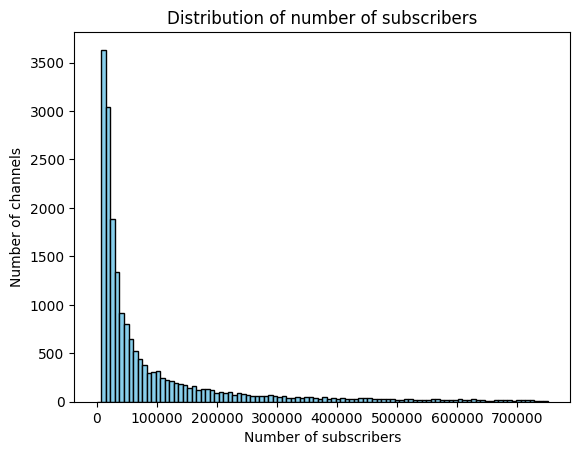

In [6]:
plt.hist(channels_df['subscribers'], bins=100, range=(0, channels_df['subscribers'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Number of subscribers')
plt.ylabel('Number of channels')
plt.title('Distribution of number of subscribers');

Unsurprsingly, the distribution is **right-skewed**, with a **long tail** of channels having a very high number of subscribers.

Let's bin channels depending on their popularity : different **subscriber bins** often **represent different stages** of a channel's development and **reduces variability** within each segment, which can make trends more **statistically significant** and **clearer** to interpret.

The ranges will be as follows.
- $10000$ - $100000$: **Small** channels, mostly posting videos as a hobby
- $100000$ - $1000000$: **Medium** size channels that start reaching mainstream status.
- $1000000$ or more: **Large** channels that can reach worlwide popularity, they are quite rare

In [7]:
sized_channel_dfs = [
    segment_channel(channels_df, 10_000, 100_000),
    segment_channel(channels_df, 100_000, 1_000_000),
    segment_channel(channels_df, 1_000_000, float('inf'))
]

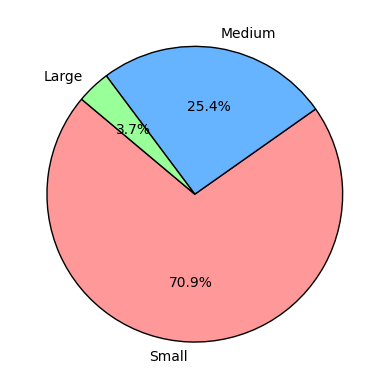

In [8]:
labels = ["Small", "Medium", "Large"]
plt.pie(
    [len(df) for df in sized_channel_dfs],
    labels=labels, 
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=['#ff9999', '#66b3ff', '#99ff99'] 
);

## Time-series

Now, before going any further, let's examine the **time-series** data. Since we begin to deal with quite a **lot of data**, we'll start to use the `polars` library.

In [9]:
timeseries_df = pl.read_csv(TIMESERIES_PATH, separator='\t')

In [10]:
timeseries_df.null_count()

channel_id,datetime,views,delta_views,subs,delta_subs,videos,delta_videos
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


Again, let's just check a few statistics.

In [11]:
timeseries_df.describe()

statistic,channel_id,datetime,views,delta_views,subs,delta_subs,videos,delta_videos
str,str,str,f64,f64,f64,f64,f64,f64
"""count""","""2825331""","""2825331""",2.825331e6,2.825331e6,2.825331e6,2.825331e6,2.825331e6,2.825331e6
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,3.8548e7,260491.167058,137524.995662,932.751145,568.914608,2.756867
"""std""",null,null,2.8083e8,1.5949e6,800529.3558,6506.63577,1253.742832,8.623283
"""min""","""UC--7oyGW0N7fMf164-ZXljQ""","""2015-01-05 00:00:00""",1.0,0.0,1.375,0.0,0.0,0.0
"""25%""",null,null,1007352.2,6442.625,8403.625,13.143706,58.0,0.0
"""50%""",null,null,4.1019e6,29001.625,19918.819444,92.895255,196.0,1.0
"""75%""",null,null,1.5478e7,119188.0625,66846.385417,421.875,588.0,3.0
"""max""","""UCzzSPRyMYUw6IGueHr1K0Jg""","""2019-09-30 01:00:00""",2.3551e10,5.04165045e8,1.0109e8,1.9551e6,63221.0,2994.0


Here, it makes no sense to study the **mean** and **standard deviation** of the **views**, **subs** and **videos** columns, as they are **cumulative** values. The meaningful insights are the following.
- The **mean weekly delta subscribers** and **views** are **~930** and **~260k** respectively, with huge **standard deviations** also indicating extreme outliers.
- The **mean weekly delta videos** is **~2.8**, which seems to a reasonable value, but looking at the **maximum** tells us that one channel once posted almost **3k** videos in a week !

Now that we have a better understanding of both our channels and timeseries data, let's try to find a correlation between the **number of subscribers** and the **number of views**. We'll divide our analysis between previously determined *small*, *medium* and *large* channels.

 1. Firstly, let's merge the **number of subscribers**  with the **total number of views** for each channel, which is the last value of our timeseries for each channel.

In [12]:
views_df = (
    timeseries_df
    .group_by('channel_id')
    .agg(pl.col('views').last())
)

In [13]:
sized_sub_views_dfs = [
    views_df.join(pl.from_pandas(df), on='channel_id', how='inner')
    for df in sized_channel_dfs
]

2. Then we'll leverage the `regplot` function from `seaborn` to plot the **number of subscribers** against the **number of views** for each channel, and color the points depending on the channel's size.

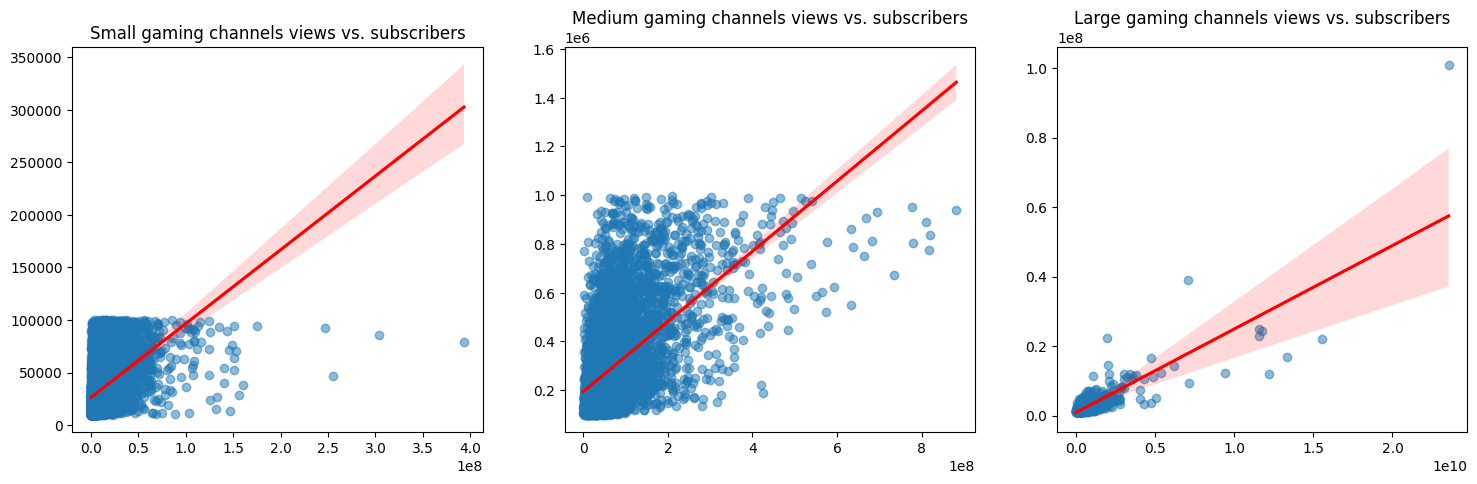

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Creates a 1x3 grid of plots
for i, (df, name) in enumerate(zip(sized_sub_views_dfs, ["Small", "Medium", "Large"])):
    sns.regplot(
        data=df,
        x="views",
        y="subscribers",
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "red"},
        ax=axes[i]
    )
    axes[i].set_title(f"{name} gaming channels views vs. subscribers")

In [15]:
print("Correlation coefficient between views and subscribers for gaming channels:")
for df, name in zip(sized_sub_views_dfs, ["Small", "Medium", "Large"]):
    corr = df.select(pl.corr("views", "subscribers")).item()
    print(f"{name} channels: {corr:.2f}")

Correlation coefficient between views and subscribers for gaming channels:
Small channels: 0.41
Medium channels: 0.59
Large channels: 0.83


We have evidence that the number of views is positively correlated to the number of subscribers. This correlation is weak for small channels, moderate for medium channels and strong for large channels. 

We interpret this as follows. Small channels tend to produce content that people will watch **regardless of their subscriber count**, only because they are interested, whereas medium and large channels tend to have a more loyal audience that will watch **most of their content** due to their **popularity**.

## Video metadata

Let's dive into the **videos metadata**. Since it is quite huge, we'll use `polars` library to load the data.

In [16]:
# ~30s
videos_df = pl.read_csv(VIDEOS_PATH, separator='\t')

First, let's get some insights about our data, starting with the number of gaming videos we have at our disposal.

In [17]:
len(videos_df)

13720303

We have more than **13.7 million** videos, that's quite a good knowledge base ! Let's get some statistics.

In [18]:
# ~19s
videos_df.describe()

statistic,title,tags,upload_date,view_count,like_count,dislike_count,duration,channel_id,display_id
str,str,str,str,f64,f64,f64,f64,str,str
"""count""","""13720303""","""13720303""","""13720303""",1.3720302e7,1.3588285e7,1.3588285e7,1.3720303e7,"""13720303""","""13720303"""
"""null_count""","""0""","""0""","""0""",1.0,132018.0,132018.0,0.0,"""0""","""0"""
"""mean""",null,null,null,75982.51334,1276.932821,52.566897,1432.527999,null,null
"""std""",null,null,null,715529.614668,8368.827465,663.013354,2791.670363,null,null
"""min""",""" 5 AWESOME MINECRAFT BANNER DE…","""""","""2006-02-22 00:00:00""",0.0,0.0,0.0,1.0,"""UC--2EbuIuBOGgGqPiJxi3rg""","""----0MtozP4"""
"""25%""",null,null,null,734.0,14.0,0.0,304.0,null,null
"""50%""",null,null,null,4113.0,81.0,3.0,698.0,null,null
"""75%""",null,null,null,22845.0,454.0,17.0,1377.0,null,null
"""max""","""🩹🧛 How to Cure Vampirism in Sk…","""🥋 Shaolin Shuffle Easter Eggs …","""2019-11-15 00:00:00""",1.1425e9,5.067807e6,1.111032e6,153430.0,"""UCzzt-UNlRHbEFY3rEpFpuXw""","""zzzzYXMnvvs"""


It's interesting to see that, **on average**, between may 2005 and october 2019, the **~137k** studied english channels have **~76k views** per video, and their videos last **~24 minutes**. The same pattern applies for the **views** as for the channels **subscribers**, which makes sense: there are extreme outliers which add a lot of vairance to the metrics.

Let's try to visualize the distribution of the number of views and the duration of the videos. We'll create a sample of $5\%$ of the data to avoid runtime issues, while still being representative of the whole dataset.

In [19]:
# ~1min
videos_sample_df = videos_df.sample(fraction=0.05, seed=RANDOM_STATE)
print(f'There are {len(videos_sample_df)} videos in the sample dataset.')

There are 686015 videos in the sample dataset.


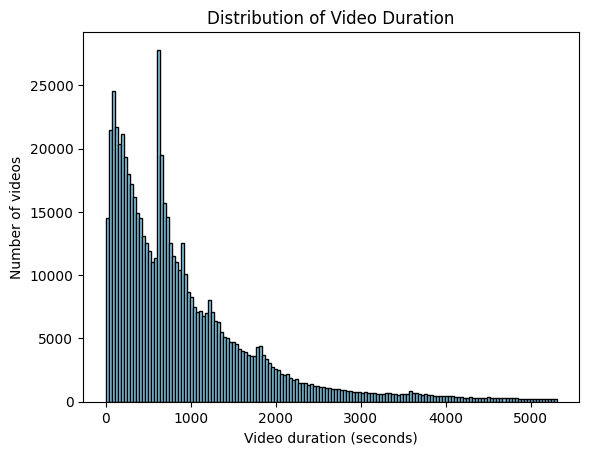

In [26]:
plt.hist(videos_sample_df['duration'], bins=150, range=(0, videos_sample_df['duration'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Video duration (seconds)')
plt.ylabel('Number of videos')
plt.title('Distribution of Video Duration');

It's very interesting here to notice the peak at **10min**, which at the period captured by thie dataset, corresponded to the minimum duration of a video that allowed content creators to freely decide the number of ads they could insert, maximizing their videos' **monetization**.

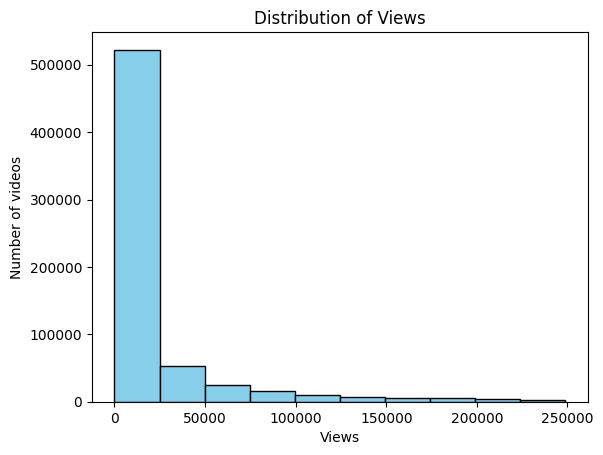

In [27]:
plt.hist(videos_sample_df['view_count'], bins=10, range=(0, videos_sample_df['view_count'].quantile(0.95)), color='skyblue', edgecolor='black')
plt.xlabel('Views')
plt.ylabel('Number of videos')
plt.title('Distribution of Views');

Now, let's visualize the distribution accross time of the **upload date** of our gaming videos.

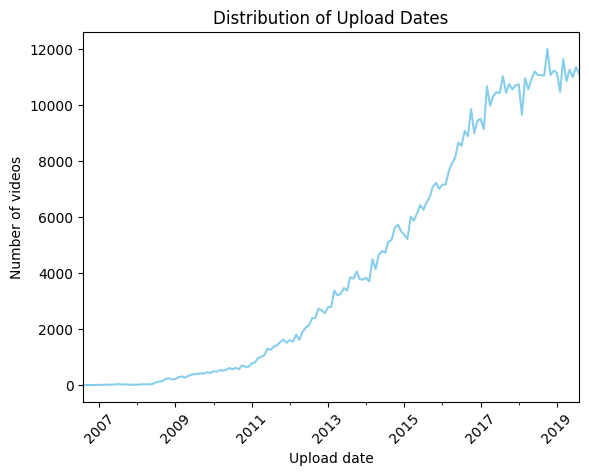

In [20]:
# ~4s
upload_dates = (
    videos_sample_df
    .with_columns(
        pl.col("upload_date").str.to_date(format="%Y-%m-%d %H:%M:%S"),
    )
    .with_columns(
        pl.col("upload_date").dt.month_start()
    )
    .get_column("upload_date")
)

monthly_counts = upload_dates.value_counts().sort("upload_date").to_pandas()
monthly_counts.plot(kind='line', x='upload_date', y='count', color='skyblue', legend=False)
plt.xlim(right=pd.Timestamp('2019-08-31'))
plt.xlabel('Upload date')
plt.ylabel('Number of videos')
plt.title('Distribution of Upload Dates')
plt.xticks(rotation=45);


It follows the general trend of YouTube, with **increasing uploads** over time.

#### Most common tags & titles

Now, let's dive deeper into our `title` and `tags` field. We noticed that the `tags` field is a list of tags, where they're separated by a comma. What would be super interesting to do is extracting all different tags and see which ones are the most common. We carry on with our sample of $5\%$ of the data.

In [21]:
# ~30s
tag_counts = (
    videos_sample_df
    .select('tags')
    .with_columns(pl.col("tags").str.to_lowercase())
    .with_columns(pl.col("tags").str.split(","))
    .explode("tags")
    .group_by("tags")
    .count()
    .sort("count", descending=True)
)
tag_counts.head(15)

tags,count
str,u32
"""gameplay""",139901
"""game""",74830
"""walkthrough""",72256
"""gaming""",67414
"""games""",61472
…,…
"""play""",39434
"""commentary""",38891
"""minecraft""",34934


Very interesting ! We can already see that `minecraft` is tagged on a huge number of videos.

Let's apply the same methodology to `title` filed, but his time splitting the words by space.

In [22]:
# ~10s
title_counts = (
    videos_sample_df
    .select('title')
    .with_columns(pl.col("title").str.to_lowercase())
    .with_columns(pl.col("title").str.split(" "))
    .explode("title")
    .group_by("title")
    .count()
    .sort("count", descending=True)
)
title_counts.head(15)

title,count
str,u32
"""-""",404698
"""|""",147838
"""the""",137205
"""of""",83329
"""part""",73223
…,…
"""in""",41913
"""and""",38680
"""play""",37763


As we can see, this is less representative. We can try to check some famous games in the `tag_counts` to evaluate their interest.

In [23]:
print(f'Number of tags containing "fifa": {tag_counts.filter(pl.col("tags") == "fifa").select("count").item()}')
print(f'Number of tags containing "minecraft": {tag_counts.filter(pl.col("tags") == "minecraft").select("count").item()}')
print(f'Number of tags containing "league of legends": {tag_counts.filter(pl.col("tags") == "league of legends").select("count").item()}')

Number of tags containing "fifa": 5064
Number of tags containing "minecraft": 34934
Number of tags containing "league of legends": 10317


### Video games dataset

 Now, we will cross our dataset with another one, containing an almost-comprehensive list of more than **41k** unique commercial video games. It is available [here](https://www.kaggle.com/datasets/matheusfonsecachaves/popular-video-games). So as to keep this study manageable, we will only focus on the first **~1k** most popular games, since we assume they represent the vast majority of YouTube gaming videos.
 
Let's load and filter out the dataset.

In [24]:
games_df = pd.read_csv(GAMES_PATH, index_col=0).drop_duplicates("Title").reset_index(drop=True)
games_df.head(3)

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
0,Elden Ring,"Feb 25, 2022","['FromSoftware', 'Bandai Namco Entertainment']","Elden Ring is a fantasy, action and open world...","['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Adventure', 'RPG']",4.5,21K,4.1K,5.6K,5.5K,4.6K,3K
1,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",The Legend of Zelda: Breath of the Wild is the...,"['Wii U', 'Nintendo Switch']","['Adventure', 'Puzzle']",4.4,35K,3.1K,5.6K,3K,5.1K,3K
2,Hades,"Dec 07, 2018",['Supergiant Games'],A rogue-lite hack and slash dungeon crawler in...,"['Windows PC', 'Mac', 'PlayStation 4', 'Xbox O...","['Adventure', 'Brawler', 'Indie', 'RPG']",4.3,25K,3.5K,7.3K,4K,3.2K,2.1K


We'll use the `Plays` feature to estimate the popularity of the games, and we'll use a cutoff of **2k** games to keep.

In [25]:
cutoff = 2000
games_df["Plays_Numeric"] = games_df["Plays"].apply(lambda x: float(x.replace('k', '').replace('K', '')) * 1000 if "k" in x or "K" in x else float(x))
games_df = games_df.sort_values(by="Plays_Numeric", ascending=False).drop(columns=["Plays_Numeric"])
games_df = games_df.iloc[:cutoff]

Then, we'll remove game names that are too short and those that are common english names, as they are likely to be noise. We pick the list of common english names [here](https://github.com/dwyl/english-words).

In [26]:
with open(WORDS_PATH, "r") as f:
    words = {line.strip() for line in f}

games_df = games_df[(games_df["Title"].str.len() > 4) & ~(games_df["Title"].str.lower().isin(words))].reset_index(drop=True)

Some video games are just specific versions of other games, see for instance the *Tetris* example.

In [27]:
games_df[games_df["Title"].str.contains("Tetris")]

,Title,Release_Date,Developers,Summary,Platforms,Genres,Rating,Plays,Playing,Backlogs,Wishlist,Lists,Reviews
150,Tetris,"Nov 01, 1989",['Nintendo'],Tetris is a tile-matching puzzle video game. T...,['NES'],"['Arcade', 'Puzzle']",4.1,11K,60,211,86,797,410
379,Tetris 99,"Feb 13, 2019","['Nintendo', 'Arika Co., Ltd.']",A blockbuster battle royale!\n99 players but o...,['Nintendo Switch'],"['Arcade', 'Puzzle']",3.6,6.6K,132,213,79,414,280
828,Puyo Puyo Tetris,"Feb 06, 2014","['Sega', 'Sonic Team']","""Two puzzle game juggernauts collide as Tetris...","['Windows PC', 'Wii U', 'PlayStation 4', 'Play...","['Puzzle', 'Strategy']",3.8,3.3K,60,357,210,255,151
980,Tetris Effect,"Nov 09, 2018","['Enhance', 'Monstars Inc.']",Named after a real-world phenomenon where play...,"['Windows PC', 'PlayStation 4', 'SteamVR', 'Pl...","['Music', 'Puzzle']",4.2,2.8K,53,359,356,466,183
1131,Tetris Effect: Connected,"May 14, 2020","['Enhance', 'Resonair']",Tetris Effect: Connected adds an all-new robus...,"['Windows PC', 'PlayStation 4', 'Xbox One', 'P...","['Arcade', 'Indie', 'Music', 'Puzzle']",4.2,2.4K,137,274,236,426,249
1774,Tetris DS,"Mar 20, 2006","['Nintendo SPD Production Group No. 2', 'Ninte...",You can rediscover the timeless puzzle game Te...,['Nintendo DS'],['Puzzle'],4.1,1.3K,5,117,74,189,84


Since we're not interested in specific versions but rather in the game itself, we will remove all games that are a superstring of another game.

In [28]:
games_df = games_df[games_df['Title'].apply(lambda x: not any(other in x for other in games_df['Title'] if x != other))].reset_index(drop=True)

Since the titles and tags are quite noisy and may contain a lot of irrelevant information as well as different names for a given video game (e.g. *LoL* for *League of Legends*, *gta* for *Grand Theft Auto V*, etc.), we searched for a good and effective way to extract the game names from the `title` and `tags` field. 

- We first tried to use **TF-IDF** embeddings, but it did not yield satisfactory results are rare words were given too much importance : a title containing the words *mafia* and *minecraft* would be assigned to the game *mafia ii*, even though it is more likely to be about *minecraft*. 
- We then tried to use **Sentence Transformers** to embed the game names and the titles/tags, and then compute the cosine similarity between them. It did not yield satisfactory results either. 

- What works the best is in fact quite simple. We lowercase and remove punctuation from all video games names, titles and tags, and then we start by looking if a game name is entirely contained in the video title. If it is, we assign the video to this game. If it is not, we look if a game name is entirely contained in one of the tags. If there is only one game name, we assign the video to this game. Otherwise, if there is no game or several games in the tags, we do not assign the video. This way, we can assign a game to **~50%** of the videos.

During **PM3**, we could go further in our analysis by leveraging **LLMs** to acomplish this task for more videos, but this would require a lot of computational power and time. We could also investigate the use of game initials, since it is a commonly used pattern in video tags (e.g. *gta v* for *Grand Theft Auto V*, *lol* for *League of Legends*, *r6* for *Tom Clancy's Rainbow Six Siege*, *cod* for *Call of Duty*, etc.)

 We'll only provide a **Proof-of-Concept** here, as it is quite slow (~1h) to process the whole dataset. We'll only process the previously devised sample (`pandas_sample_df`) of $5\%$ of the data.

In [29]:
# ~20s
videos_sample_df = videos_sample_df.with_columns(
    pl.col("title").map_elements(preprocess_name),
    pl.col("tags").map_elements(preprocess_name)
)
game_titles = games_df["Title"].apply(preprocess_name).tolist()

In [30]:
# ~1min40s
with_game_df = videos_sample_df.with_columns(
    [
        pl.struct(["title", "tags"])
        .map_elements(
            w_pbar(
                tqdm(total=len(videos_sample_df)),
                lambda row: map_to_game(row["title"], row["tags"], game_titles),
            ),
            return_dtype=str,
        )
        .alias("video_game")
    ]
).drop_nulls(subset="video_game")

100%|██████████| 686015/686015 [01:30<00:00, 7566.33it/s]


In [38]:
print(f'Percentage of classified games over the sample : {len(with_game_df) / len(videos_sample_df) * 100:.2f}%')

Percentage of classified games over the sample : 49.82%


Almost half of our sample was assigned a game ! We can now explore what are the top-15 most popular games in our dataset !

In [39]:
with_game_df.get_column("video_game").value_counts().sort("count", descending=True).head(10)

video_game,count
str,u32
"""minecraft""",38509
"""fortnite""",18837
"""call of duty""",18473
"""league of legends""",11681
"""roblox""",10318
"""grand theft auto""",10143
"""dota 2""",7472
"""super smash bros""",4705
"""final fantasy""",4016


Unsurprisingly, YouTube is dominated by *minecraft*, *fortnite*, *call of duty*, *league of legends*, ... We'll create a subset of our channels with their top video game assigned to them.

In [40]:
channels_top_game_df = (
    with_game_df
    .group_by(["channel_id", "video_game"])
    .agg(pl.count().alias("play_count"))
    .sort(["channel_id", "play_count"], descending=True)
    .group_by("channel_id")
    .agg(pl.col("video_game").first().alias("top_game"))
)

Let's see which games are **the most frequently** the **main game** our sample of **channels**.

In [41]:
channels_top_game_df.get_column("top_game").value_counts().sort("count", descending=True).head(10)

top_game,count
str,u32
"""fortnite""",2174
"""minecraft""",1839
"""call of duty""",1142
"""roblox""",743
"""grand theft auto""",632
"""league of legends""",476
"""super smash bros""",255
"""world of warcraft""",201
"""counterstrike""",177


### E-sport tournaments dataset

Let's focus on our second additional dataset, which contains 200 esports tournaments with large prize moneys. It can be found [here](https://www.kaggle.com/datasets/hbakker/esports-200-tournaments).

In [42]:
esports_df = pd.read_csv(ESPORTS_PATH).drop(columns=['City', 'GameID', 'Country', 'TeamPlay'])

We convert the columns to the **appropriate formats** : 
- we drop rows when `StartDate` is **before January 2015** or `EndDate` is **after September 2019** to match the timeseries dataset
- we convert the `StartDate` and `EndDate` columns to `datetime` format, and we handle wrong inputs
- we exclude tournaments lasting **more than 60 days**, as they are more representative of a season than a tournament

In [44]:
esports_df['TotalUSDPrize'] = esports_df['TotalUSDPrize'].round().astype(int)
esports_df[['StartDate', 'EndDate']] = esports_df[['StartDate', 'EndDate']].apply(pd.to_datetime, format='%m/%d/%y')
esports_df = esports_df[
    (esports_df['StartDate'] > '2015-01-01') & 
    (esports_df['EndDate'] < '2019-09-30') & 
    (esports_df['StartDate'] < esports_df['EndDate'])
].reset_index(drop=True)
esports_df = esports_df[(esports_df['EndDate'] - esports_df['StartDate']).dt.days <= 60].rename(columns={
    'TournamentName': 'tournament_name',
    'StartDate': 'start_date',
    'EndDate': 'end_date',
    'TotalUSDPrize': 'cash_prize'
})

We create a new column `video_game`, which contains the name of the game associated to the tournament. We use famous tournaments names patterns to resolve a game name from the tournament name.

In [45]:
game_map = {
    'Fortnite': 'fortnite',
    'RLCS': 'rocket league',
    'CS:GO|ESL|Esports Championship Series|ELEAGUE|IEM|MLG|PGL|FACEIT': 'counter strike',
    'King': 'honor of kings',
    'Dota|The International|DAC|Major 20|DreamLeague|EPICENTER': 'dota 2',
    'League of Legends|LoL|Mid-Season Invitational': 'league of legends',
    'Overwatch': 'overwatch',
    'PUBG': 'pubg',
    'Call of Duty|CoD|CWL': 'call of duty',
    'Six Invitational': 'tom clancy\'s rainbow six siege',
    'Halo': 'halo',
    'NBA': 'nba 2k',
    'Smite': 'smite',
    'Shadowverse': 'shadowverse',
    'Hearthstone': 'hearthstone',
    'StarCraft|WCS': 'starcraft',
    'HGC|Heroes of the Storm': 'heroes of the storm',
    'Mythic': 'mythic',
    'Quake': 'quake',
    'eRace|F1': 'formula 1',
    'CrossFire': 'crossfire'
}

esports_df['video_game'] = esports_df['tournament_name'].apply(lambda x: next((game for pattern, game in game_map.items() if pd.Series(x).str.contains(pattern, case=False, na=False).any()), ''))

Let's plot the **mean prize money** per game, which appears to be quite **unbalanced**. We will further analyse the causes and consequences of this during Milestone 3.

In [46]:
mean_prizes_df = esports_df.groupby('video_game')['cash_prize'].mean().astype(int).reset_index()
mean_prizes_df = mean_prizes_df.sort_values(by='cash_prize', ascending=False)

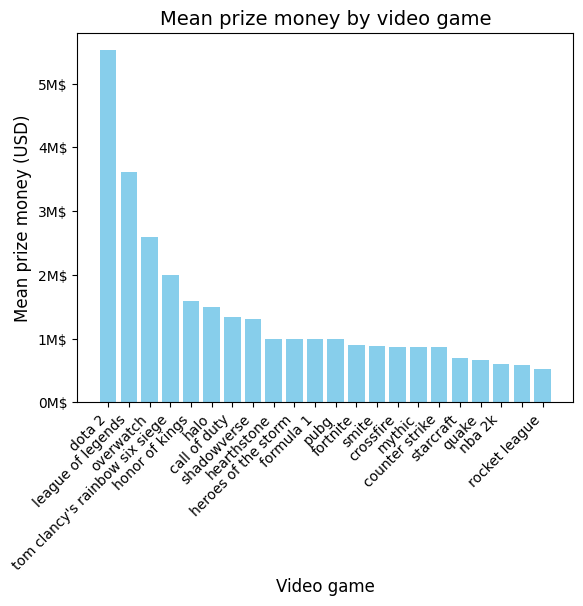

In [47]:
plt.bar(mean_prizes_df["video_game"], mean_prizes_df["cash_prize"], color='skyblue')
plt.xlabel('Video game', fontsize=12)
plt.ylabel('Mean prize money (USD)', fontsize=12)
plt.title('Mean prize money by video game', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.0f}M$'));

Let's create a sub-dataset with the $5$ games with the highest mean prize moneys and only $5$ tournaments maximum for these games. This make our analysis more feasible for this milestone, and acts as a **Proof of Concept**.

In [48]:
esports_df = esports_df[esports_df['video_game'].isin(mean_prizes_df["video_game"].head(5))].groupby('video_game').head(5).reset_index(drop=True)


Let's try to cluster the channels based on their **time-series** data, using their last number of subscribers, and see the distribution. Recall that the number of channels shown is limited as we are currently presenting only a sample. A more comprehensive analysis will be conducted for Milestone 3.

In [49]:
cluster_timeseries(timeseries_df).get_column("cluster").value_counts()

cluster,count
cat,u32
"""1""",817017
"""2""",769296
"""3""",420177
"""4""",590166
"""5""",228675


Let's take the highest-paid tournament, which is **The International** for **Dota 2**, and see when it occurs.

In [50]:
esports_df[esports_df["video_game"] == "dota 2"].head(5)

,tournament_name,start_date,end_date,cash_prize,video_game
0,The International 2019,2019-08-15,2019-08-25,34330069,dota 2
1,The International 2018,2018-08-15,2018-08-25,25532177,dota 2
2,The International 2017,2017-08-02,2017-08-12,24687919,dota 2
3,The International 2016,2016-08-03,2016-08-13,20770460,dota 2
4,The International 2015,2015-08-03,2015-08-08,18429613,dota 2


It occurs every month of August, this must be very interesting to observe the impact of this tournament on the number of views of **Dota 2** channels on YouTube ! We pick the timeseries data for those previously defined channels (in `channels_top_games_df`), and we plot the rolling weekly average of the difference in views over the years. Green lines represent the tournaments dates.

We cluster the channels according to their number of subscribers to have a more fine-grained analysis.

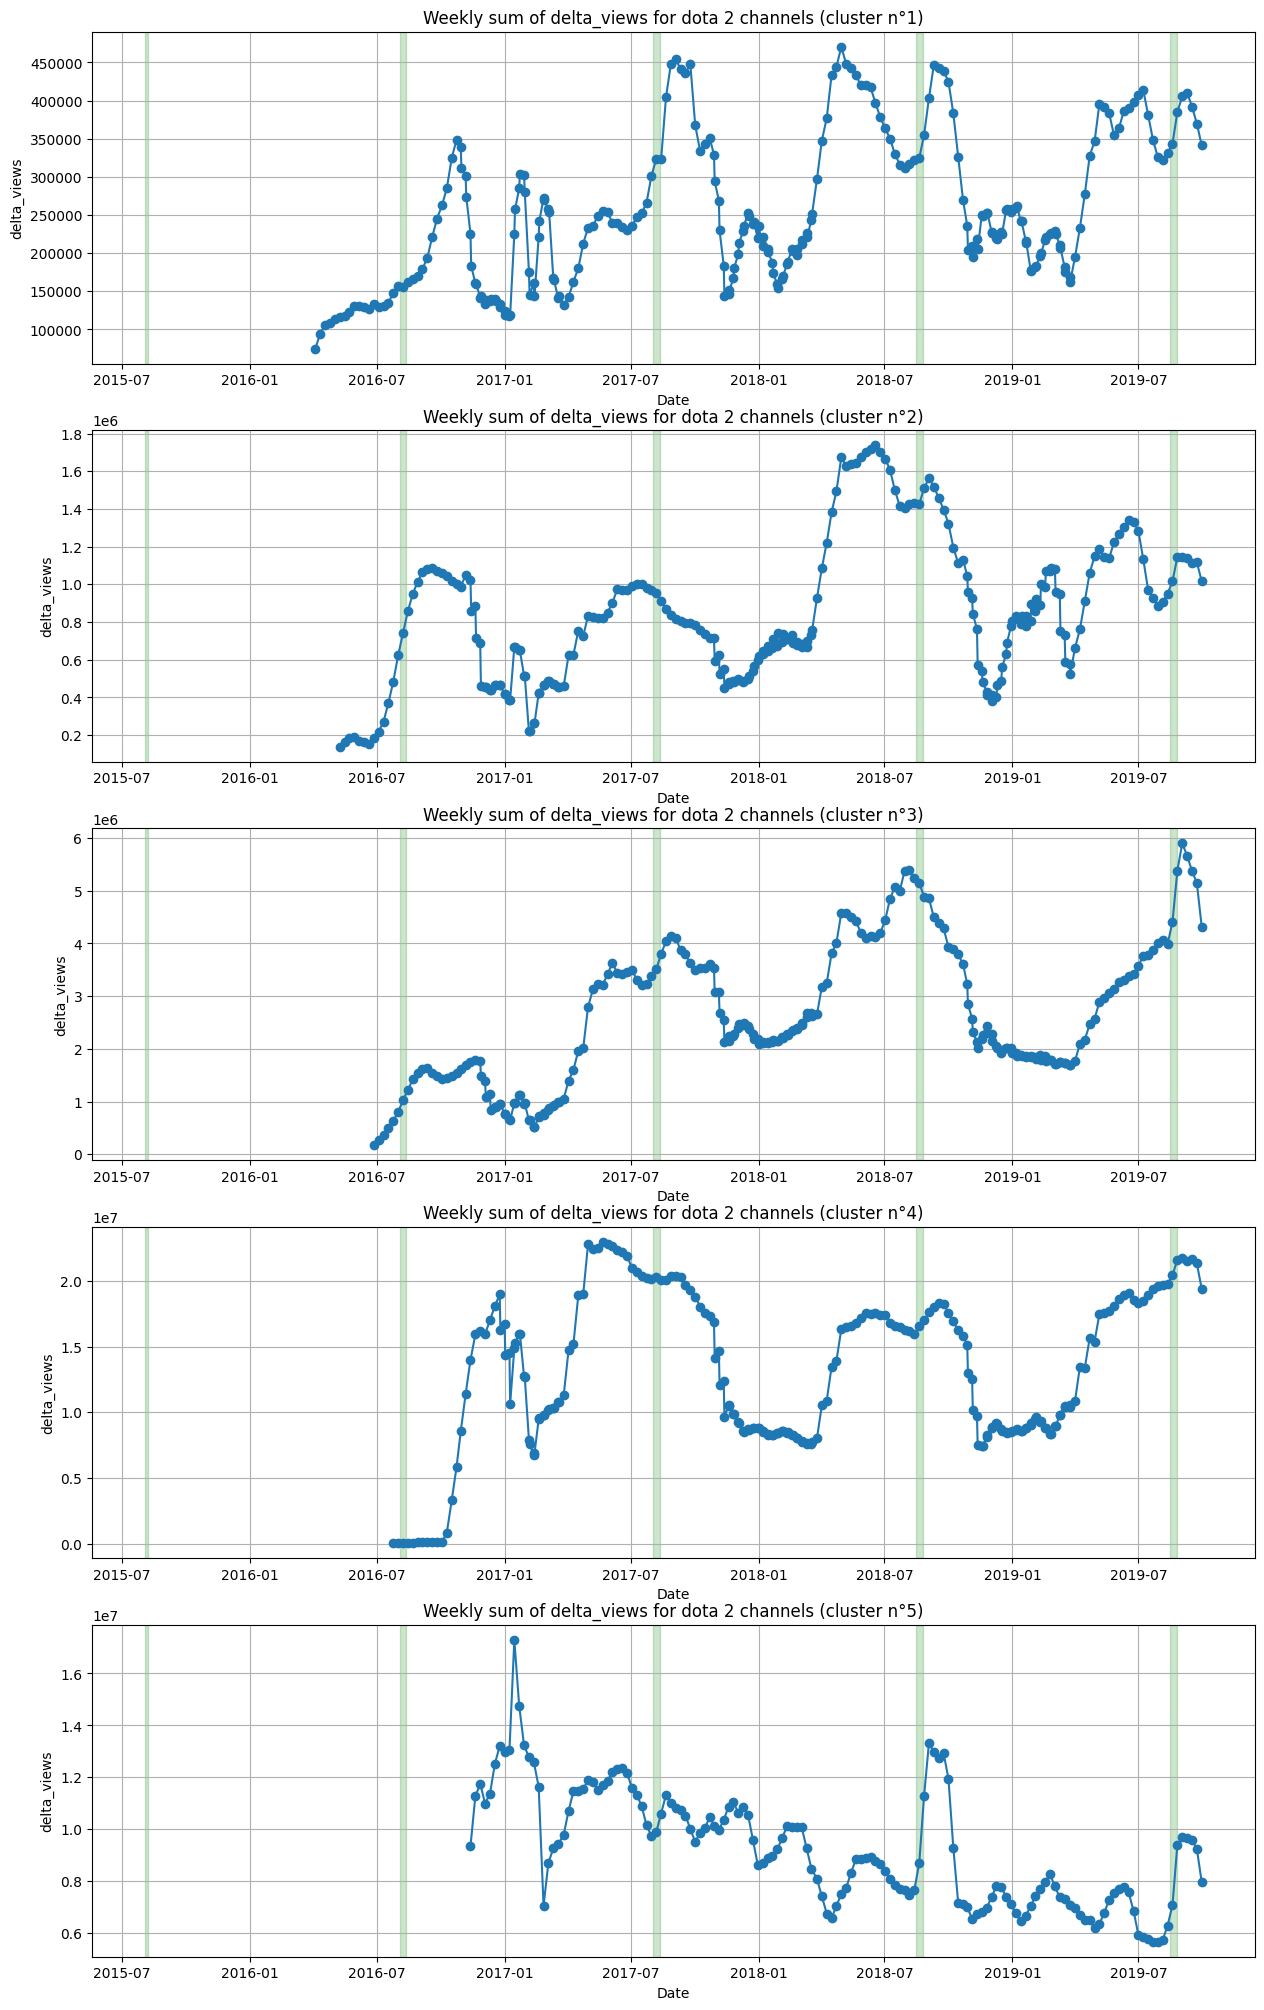

In [51]:
plot_clusters(timeseries_df, channels_top_game_df, esports_df, 'dota 2')

How interesting is this ! For cluster n°$1$, there are high peaks after each edition of the tournament ! This clearly indicates a positive correlation between occurences of the tournament and **Dota 2** channels activity. Higher clusters, representing channels with more subscribers, tend to have a more stable activity, but still show a peak after the tournament. We will push this further during Milestone 3.

## Comments & Gaming communities

We now want to extract community insights using the **comments** part of the dataset. More precisely, we want to link viewers that have commented on **plenty of channels**, to see if some patterns emerge.

Our goal is to join the data contained in the channel data (containing the mapping from the `channel_id` to the `channel_name`), the video metadata (containing the mapping from the `video_id` to the `channel_id`), and the comments (containing the mapping from the `video_id` to the `author`). By doing, so we will have the mapping from the `author` to the `channel_name` which will allow us to see the ones that have commented on multiple channels, and observe what are the **most common links** between channels, to identify potential **communities** and clusters.

Firstly, we join our channel data with the video metadata, and keep only the needed columns (`display_id` to map to the comments' authors, `channel` to adress channels by their name instead of ID's, and `subscribers` to represent bigger channels with bigger points on the graphs).

In [ ]:
# ~35s
channels_df = pl.read_csv(CHANNELS_PATH, separator="\t")
videos_df = pl.read_csv(VIDEOS_PATH, separator='\t')

In [ ]:
# ~1min40s
joined_df = videos_df.join(channels_df, on="channel_id", how="inner")

joined_df = joined_df.select(
    [
        pl.col("display_id"),
        pl.col("channel_id"),
        pl.col("channel_name"),
        pl.col("subscribers"),
    ]
).rename({"channel_name": "channel"})

joined_df.unique("channel").sort("subscribers").reverse().head(10)

display_id,channel_id,channel,subscribers
str,str,str,i64
"""HLZA-s_W0Ak""","""UC-lHJZR3Gqxm24_Vd_AJ5Yw""","""PewDiePie""",101000000
"""1DtxbdA5I4M""","""UCEdvpU2pFRCVqU6yIPyTpMQ""","""Marshmello""",39100000
"""JhVcyE4zcDg""","""UCKqH_9mk1waLgBiL2vT5b9g""","""VanossGaming""",24800000
"""AKTPCU3kOLU""","""UC7_YxT-KID8kRbqZo7MyscQ""","""Markiplier""",24400000
"""ayx-22zCfZY""","""UCYzPXprvl5Y-Sf0g4vX-m6g""","""jacksepticeye""",22833014
"""NIr4vE8K7WM""","""UCAW-NpUFkMyCNrvRSSGIvDQ""","""Ninja""",22400000
"""-SVnrDek3EI""","""UCS5Oz6CHmeoF7vSad0qqXfw""","""DanTDM""",22100000
"""kXtNUkEMgwk""","""UCpGdL9Sn3Q5YWUH2DVUW1Ug""","""PopularMMOs""",16900000
"""-dkD8EHuGq8""","""UCYVinkwSX7szARULgYpvhLw""","""Ali-A""",16500000


It is now time to proceed on comments. For **PM2**, we just took a 100M subset of the comments for the sake of performance.

In [ ]:
comments_df = pl.scan_csv(COMMENTS_PATH, separator="\t", has_header=True)

We now join the previously joined_data with the comments (`display_id` to `video_id`), and we suppress the number of likes and replies since they are not needed for our analysis.

In [ ]:
comments_video_channels = comments_df.join(
    joined_df.lazy(), left_on="video_id", right_on="display_id"
)

comments_channels = comments_video_channels.select(
    [pl.col("author"), pl.col("channel")]
).unique()

comments_channels.head().collect()

For our graph, the users that commented on only one channel are **not relevant** for our analysis, because they don't illustrate any sort of connection between channels communities. We thus filter them out.

In [ ]:
counts_per_author = (
    comments_channels.group_by("author")
    .agg(pl.col("channel").count().alias("count"))
    .filter(pl.col("count") > 1)
)

# We remove the authors that commented on only one channel
comments_several_channels = comments_channels.join(
    counts_per_author, on="author", how="inner"
).select(["author", "channel"])

Our final graph input needs to be of the form `source, target, weight`, where `source` and `target` are the channel names, and `weight` is the number of users that commented on both channels. We then aggregate the data to have the final graph.

Note that we **alphabetically sorted** the two channels that are linked by the edge, to avoid duplicates (i.e. if an author made comments under channels A, B and C, we would add 3 edges A-B, A-C and B-C but not the B-A, C-A and C-B ones).

In [ ]:
pairs = (
    comments_several_channels.join(comments_several_channels, on="author", how="inner")
    .filter(pl.col("channel") < pl.col("channel_right"))
    .select(["channel", "channel_right"])
)

pairs_grouped = pairs.group_by(["channel", "channel_right"]).agg(
    pl.col("channel").count().alias("weight")
)

pairs_grouped.collect()

As the generation for 100M comments took a lot of time, we decided to **save** the final graph in a `.csv` file to avoid reprocessing the data.

To improve the meaning of our edges that connects two channels, we decided to **keep only** the edges that have a weight of **at least 1000**. This way, we can focus on the **most relevant** connections between channels.

In [ ]:
pairs_grouped_filtered = (
    pl.scan_csv("edges.csv")
    .filter(pl.col("weight") > 1000)
    .sort("weight", descending=True)
)

edges = pairs_grouped_filtered.collect()

edges.head()

Now that we have all the edges we want, we can get all the **nodes** (channes) from the edges and before plotting the graph, we first get back the **subscribers** count for each channel to represent them with bigger points on the graph.

In [ ]:
channels_filtered = edges.select(["channel"]).unique()

nodes = (
    channels_filtered.join(
        channels_df, left_on="channel", right_on="name_cc", how="inner"
    )
    .select(["channel", "subscribers_cc"])
    .sort("subscribers_cc", descending=True)
)

nodes.head()

For the final graph, we used the `networkx` library to plot the graph, and we used the `kamada_kawai_layount`, which separates well the clusters to have a better visualization of the communities. The `best_partition` function from the `community` module allows us to identify the communities in the graph.

More precisely, each node represents a **channel** (the size of the node is proportional to the number of subscribers of the channel), and each edge represents a **connection between two channels** (when the weight of the edge is at least 1000).

In [ ]:
G = nx.Graph()

for row in nodes.iter_rows(named=True):
    G.add_node(row["channel"], subscribers=row["subscribers_cc"])

for row in edges.iter_rows(named=True):
    G.add_edge(row["channel"], row["channel_right"], weight=row["weight"])

ModuleNotFoundError: No module named 'networkx'

In [ ]:
partition = community.best_partition(G, weight="weight")
pos = nx.kamada_kawai_layout(G, weight="weight")

Below are defined the **parameters** of the graph, such as **colors and sizes** of different nodes. We defined communities' colors **manually** to have a better visualization of the graph.

We also showed on the graph the names of channels that have more than **10M subscribers**, to see where the most famous YouTubers are located in the graph.

In [ ]:
clusters = set(partition.values())
colors = [
    "#39C5DB",
    "#1AA5E0",
    "#FF5450",
    "#FEBA33",
    "#E08300",
    "#4FC43D",
    "#8A52F5",
    "#3BCEAC",
    "#F4D35E",
    "#EE964B",
    "#8BC34B",
]

color_map = dict(zip(clusters, colors))

default_color = "#D3D3D3"

node_colors = [
    color_map.get(partition[node], default_color)
    for node in G.nodes
    if node in partition
]

edge_colors = [
    color_map.get(partition[edge[0]], default_color)
    for edge in G.edges
    if edge[0] in partition
]

node_sizes = [G.nodes[node].get('subscribers') for node in G.nodes()]
node_sizes = [max(size / 100000, 10) if size else 10 for size in node_sizes]

label_threshold = 10000000
labels = {node: node if G.nodes[node].get('subscribers') and (G.nodes[node].get('subscribers') > label_threshold) else '' for node in G.nodes()}

Last step is to show the graph and observe it the **communities connections** that emerged from the data!

In [ ]:
nx.draw_networkx_nodes(
    G,
    pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.1,
)

nx.draw_networkx_labels(
    G,
    pos,
    labels=labels,
    font_size=16,
    verticalalignment="bottom",
    horizontalalignment="right",
)

nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.1)

plt.gcf().set_size_inches(40, 30)
plt.show()